## Import Python packages

In [1]:
import numpy as np
import pandas as pd
import keras
from scipy.constants import g
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import seaborn as sn
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import reciprocal
from matplotlib import rc
from sklearn.inspection import permutation_importance

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import catboost
from keras import regularizers 
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras import regularizers 
from keras.models import Sequential
from keras import layers 
from keras.optimizers import RMSprop
from keras.layers import RepeatVector
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import GRU 

from sklearn.metrics import r2_score

from numpy import loadtxt
from sklearn.metrics import mean_absolute_percentage_error
import math
import pickle

Using TensorFlow backend.


## Load Models

In [2]:
Best_LSTM = tf.keras.models.load_model("bestLSTMmodel_h_dec")
Best_GRU = tf.keras.models.load_model("bestGRUmodel_h_dec")

## Load data sets

In [3]:
y_test_combined_B_Hm = loadtxt('y_test_combined_comb_hdecay.csv', delimiter=',')
X_test_combined_pro = loadtxt("X_test_combined_pro.csv", delimiter=',')
X_test_combined_pos = loadtxt("X_test_combined_pos.csv",  delimiter=',')

## Format data set for ML model

In [4]:
this_test_combined = np.zeros((X_test_combined_pro.shape[0],6,7))
for i in range(this_test_combined.shape[0]):
    for j in range(6):
        this_test_combined[i,j,:] = np.hstack((X_test_combined_pro[i,[0,1,2,3,4,5]],X_test_combined_pos[i,j])) 

## Get model predictions

In [5]:
predict_test = Best_LSTM.predict(this_test_combined)
predict_test_gru = Best_GRU.predict(this_test_combined)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

## Get evaluation metrics

In [6]:
rscore = r2_score(y_test_combined_B_Hm,predict_test)
print("LSTM R2", rscore)
result_MAPE_lstm = mean_absolute_percentage_error(y_test_combined_B_Hm,predict_test)
print("LSTM MAPE", result_MAPE_lstm)
result_MAE_lstm = mean_absolute_error(y_test_combined_B_Hm,predict_test)
print("LSTM MAE", result_MAE_lstm)

print("=== === ===")

rscore_gru = r2_score(y_test_combined_B_Hm,predict_test_gru)
print("GRU R2", rscore_gru)
result_MAPE_gru = mean_absolute_percentage_error(y_test_combined_B_Hm,predict_test_gru)
print("GRU MAPE", result_MAPE_gru)
result_GRU_lstm = mean_absolute_error(y_test_combined_B_Hm,predict_test_gru)
print("GRU MAE", result_GRU_lstm)

LSTM R2 0.9508816105129307
LSTM MAPE 0.2825744711387692
LSTM MAE 0.05006183640854824
=== === ===
GRU R2 0.9540958798312257
GRU MAPE 0.2980632702618495
GRU MAE 0.05071253270488296


## Import the data pre-processing tool trained on the training data

In [7]:
with open('scaler.pkl','rb') as f:
    scaler = pickle.load(f)

## Establish Chehalis lake conditions 

In [8]:
M_che = (1650*3000000) / ( (997)*210*(120**2) ) 
print(M_che)
che_case = np.array((1.75,0.33,M_che,0,1,1)).reshape((1,6)) ### angle, gran/solid, 2/3
che_case[:,[0,1,2,3]] = scaler.transform(che_case[:,[0,1,2,3]])
print(che_case)
che_case_pos = (np.linspace(3,22.5, num=6)).reshape((1,6))
print(che_case_pos)

1.6418302526627502
[[-0.10195611 -0.31958292  0.45415504 -0.55397781  1.          1.        ]]
[[ 3.   6.9 10.8 14.7 18.6 22.5]]


In [9]:
che_case_reshape = np.zeros((1,6,7))
for j in range(6):
    che_case_reshape[0,j,:] = np.hstack((che_case[0],che_case_pos[0,j])) 

## Chehalis lake prediction 

In [10]:
### Using Evers and Boers (2019) 
rel_amp = Best_GRU.predict(che_case_reshape)[0,2] * 0.5
R_over_h = 2 * rel_amp * math.exp(0.4*rel_amp) * ( (90/30) ** (0.2))
R_2019_equ = R_over_h * 120

print("Wave runup prediction in Chehalis Lake case is", R_2019_equ, "meters.")

Wave runup prediction in Chehalis Lake case is 41.37262798930968 meters.


## Reproduce figure

In [11]:
def make_QQ_pred_FWU_1(X_test_combined,y_test_combined,predictions_combined_grid_search):

    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'DeJavu Serif'
    fig, ax = plt.subplots()


    #plt.rcParams['text.usetex'] = True # "font.family": "Helvetica"
    #rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    #rc('text', usetex=True)
    plt.xlabel(r'Observed $H / h $, 3 $\le$ ($x$ or $r$)/$h$ $\le$ 5', fontsize=13)
    plt.ylabel(r'Predicted $ H / h$, 3 $\le$ ($x$ or $r$)/$h$ $\le$ 5', fontsize=13)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)  
    max_val = float(np.amax(y_test_combined))
    O = np.linspace(0,2,1000)
    plt.plot(O,O, color = 'k')
    plt.xlim([0,1.8])
    plt.ylim([0,1.8])
    
    count_gran = 0
    count_3dgran = 0 
    count_2dsolid = 0
    count_3dsolid = 0
    
   
            
    for i in range(X_test_combined.shape[0]):    #[F,S,M,(2or3),solid/gran (gran = 0, solid = 1),prop angle]
        if X_test_combined[i,4] == 0 and X_test_combined[i,5] == 0: 
            count_gran += 1 
        elif X_test_combined[i,4] == 1 and X_test_combined[i,5] == 0:
            count_3dgran += 1             
        elif X_test_combined[i,4] == 0 and X_test_combined[i,5] == 1:
            count_2dsolid += 1 
        elif X_test_combined[i,4] == 1 and X_test_combined[i,5] == 1:
            count_3dsolid += 1 
          
            

        
    print("Count each type in results", count_gran, count_3dgran,count_2dsolid,count_3dsolid)
    
    ys_count_gran = np.zeros((count_gran,))
    ys_count_gran_preds = np.zeros((count_gran,))
    
    ys_count_3dgran = np.zeros((count_3dgran,))
    ys_count_3dgran_preds = np.zeros((count_3dgran,))
    
    ys_count_2dsolid = np.zeros((count_2dsolid,))
    ys_count_2dsolid_preds = np.zeros((count_2dsolid,))
    
    ys_count_3dsolid = np.zeros((count_3dsolid,))
    ys_count_3dsolid_preds = np.zeros((count_3dsolid,))
    


    count_gran_c = 0
    count_3dgran_c = 0
    count_2dsolid_c = 0
    count_3dsolid_c = 0
    
    
    
    use_X_test_combined = []
    use_y_test_combined = []
    use_predictions_combined_grid_search = []
    for i in range(X_test_combined.shape[0]):
        if X_test_combined[i,-6] > 2.69 and X_test_combined[i,-6] < 5.01:
            use_X_test_combined.append(X_test_combined[i]) 
            use_y_test_combined.append(y_test_combined[i])
            use_predictions_combined_grid_search.append(predictions_combined_grid_search[i])
    use_X_test_combined = np.array(use_X_test_combined)
    use_y_test_combined = np.array(use_y_test_combined)
    use_predictions_combined_grid_search = np.array(use_predictions_combined_grid_search)
    print(use_X_test_combined.shape)    
    print(use_y_test_combined) 
    for i in range(use_X_test_combined.shape[0]):    
        if use_X_test_combined[i,4] == 0 and use_X_test_combined[i,5] == 0: 
            ys_count_gran[count_gran_c] = use_y_test_combined[i][0]
            ys_count_gran_preds[count_gran_c] = use_predictions_combined_grid_search[i][0]
            count_gran_c += 1
        elif use_X_test_combined[i,4] == 1 and use_X_test_combined[i,5] == 0:
            ys_count_3dgran[count_3dgran_c] = use_y_test_combined[i][0]
            ys_count_3dgran_preds[count_3dgran_c] = use_predictions_combined_grid_search[i][0]
            count_3dgran_c += 1
        elif use_X_test_combined[i,4] == 0 and use_X_test_combined[i,5] == 1:
            ys_count_2dsolid[count_2dsolid_c] = use_y_test_combined[i][0]
            ys_count_2dsolid_preds[count_2dsolid_c] = use_predictions_combined_grid_search[i][0]
            count_2dsolid_c += 1 
        elif use_X_test_combined[i,4] == 1 and use_X_test_combined[i,5] == 1:
            ys_count_3dsolid[count_3dsolid_c] = use_y_test_combined[i][0]
            ys_count_3dsolid_preds[count_3dsolid_c] = use_predictions_combined_grid_search[i][0]
            count_3dsolid_c += 1 
    
    print(ys_count_gran.shape, ys_count_2dsolid.shape, ys_count_3dsolid.shape, ys_count_3dgran.shape)
    print(ys_count_gran_preds.shape, ys_count_3dgran_preds.shape, ys_count_2dsolid_preds.shape,ys_count_3dsolid_preds.shape)
    
    ax.plot(ys_count_gran , ys_count_gran_preds, "x", color = 'dimgray' , label = '2D granular slides')
    ax.plot(ys_count_2dsolid , ys_count_2dsolid_preds, ".", color = 'dimgray' , label = '2D block slides')
    ax.plot(ys_count_3dgran , ys_count_3dgran_preds, "*", color = 'dimgray' , label = '3D granular slides')
    ax.plot(ys_count_3dsolid ,ys_count_3dsolid_preds, "^", color = 'dimgray' , label = '3D block slides')
    
    matplotlib.pyplot.text(0.02,0.97,"(a)", horizontalalignment='left', verticalalignment='top', fontsize=14, transform = ax.transAxes)
    ax.legend(fontsize=13, loc="lower right",facecolor='lightgrey')
    #plt.savefig("hallpaper_newer_allfourjpga", dpi=1200,bbox_inches="tight")
    plt.show()

Count each type in results 43 18 35 22
(110, 12)
[[0.17229167 0.08708333 0.05354167 0.040625   0.026875   0.01770833]
 [0.089375   0.048125   0.02854167 0.02020833 0.01229167 0.011875  ]
 [1.01416667 0.51583333 0.455      0.37583333 0.29333333 0.20791667]
 [0.11770833 0.0575     0.03395833 0.02375    0.01479167 0.00854167]
 [0.36541667 0.27875    0.17333333 0.11958333 0.07916667 0.05291667]
 [0.05479167 0.03       0.01895833 0.01375    0.00875    0.00916667]
 [0.06041667 0.036875   0.02541667 0.02       0.014375   0.01791667]
 [0.065      0.0925     0.065      0.05583333 0.04291667 0.03291667]
 [0.86791667 0.615      0.44791667 0.29125    0.19208333 0.12583333]
 [0.07104167 0.05145833 0.03833333 0.030625   0.02145833 0.01145833]
 [0.84208333 0.57541667 0.37458333 0.285      0.18458333 0.11875   ]
 [0.88708333 0.66541667 0.48791667 0.38625    0.27583333 0.18833333]
 [0.32875    0.23833333 0.15583333 0.11375    0.075      0.04958333]
 [0.84166667 0.66708333 0.45208333 0.34041667 0.223333

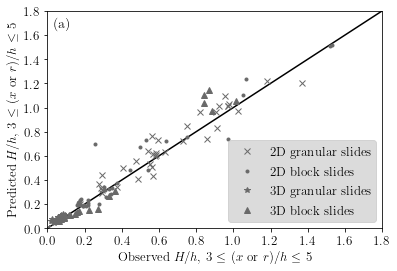

In [12]:
make_QQ_pred_FWU_1(X_test_combined_pro ,y_test_combined_B_Hm, predict_test)

In [13]:
def make_QQ_pred_FWU_3(X_test_combined,y_test_combined,predictions_combined_grid_search):

    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'DeJavu Serif'
    fig, ax = plt.subplots()

    
    #plt.rcParams['text.usetex'] = True # "font.family": "Helvetica"
    #rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    #rc('text', usetex=True)
    plt.xlabel(r'Observed $H / h $, 6 $<$ ($x$ or $r$)/$h$ $<$ 10', fontsize=13)
    plt.ylabel(r'Predicted $ H / h$, 6 $<$ ($x$ or $r$)/$h$ $<$ 10', fontsize=13)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)  
    max_val = float(np.amax(y_test_combined))
    O = np.linspace(0,2,1000)
    plt.plot(O,O, color = 'k')
    plt.xlim([0,1.8])
    plt.ylim([0,1.8])
    
    count_gran = 0
    count_3dgran = 0 
    count_2dsolid = 0
    count_3dsolid = 0
    
   
            
    for i in range(X_test_combined.shape[0]):    
        if X_test_combined[i,4] == 0 and X_test_combined[i,5] == 0: 
            count_gran += 1 
        elif X_test_combined[i,4] == 1 and X_test_combined[i,5] == 0:
            count_3dgran += 1             
        elif X_test_combined[i,4] == 0 and X_test_combined[i,5] == 1:
            count_2dsolid += 1 
        elif X_test_combined[i,4] == 1 and X_test_combined[i,5] == 1:
            count_3dsolid += 1 
          
            

        
    print("Count each type in results", count_gran, count_3dgran,count_2dsolid,count_3dsolid)
    
    ys_count_gran = np.zeros((count_gran,))
    ys_count_gran_preds = np.zeros((count_gran,))
    
    ys_count_3dgran = np.zeros((count_3dgran,))
    ys_count_3dgran_preds = np.zeros((count_3dgran,))
    
    ys_count_2dsolid = np.zeros((count_2dsolid,))
    ys_count_2dsolid_preds = np.zeros((count_2dsolid,))
    
    ys_count_3dsolid = np.zeros((count_3dsolid,))
    ys_count_3dsolid_preds = np.zeros((count_3dsolid,))
    


    count_gran_c = 0
    count_3dgran_c = 0
    count_2dsolid_c = 0
    count_3dsolid_c = 0
        
        
        
    
    use_X_test_combined = []
    use_y_test_combined = []
    use_predictions_combined_grid_search = []
    for i in range(X_test_combined.shape[0]):
        if X_test_combined[i,-4] > 4.99 and X_test_combined[i,-4] < 10.01:
            use_X_test_combined.append(X_test_combined[i]) 
            use_y_test_combined.append(y_test_combined[i])
            use_predictions_combined_grid_search.append(predictions_combined_grid_search[i])
    use_X_test_combined = np.array(use_X_test_combined)
    use_y_test_combined = np.array(use_y_test_combined)
    use_predictions_combined_grid_search = np.array(use_predictions_combined_grid_search)
    print(use_X_test_combined.shape)    
    print(use_y_test_combined)    
        
    for i in range(use_X_test_combined.shape[0]):    
        if use_X_test_combined[i,4] == 0 and use_X_test_combined[i,5] == 0: 
            ys_count_gran[count_gran_c] = use_y_test_combined[i][0]
            ys_count_gran_preds[count_gran_c] = use_predictions_combined_grid_search[i][0]
            count_gran_c += 1
        elif use_X_test_combined[i,4] == 1 and use_X_test_combined[i,5] == 0:
            ys_count_3dgran[count_3dgran_c] = use_y_test_combined[i][0]
            ys_count_3dgran_preds[count_3dgran_c] = use_predictions_combined_grid_search[i][0]
            count_3dgran_c += 1
        elif use_X_test_combined[i,4] == 0 and use_X_test_combined[i,5] == 1:
            ys_count_2dsolid[count_2dsolid_c] = use_y_test_combined[i][0]
            ys_count_2dsolid_preds[count_2dsolid_c] = use_predictions_combined_grid_search[i][0]
            count_2dsolid_c += 1 
        elif use_X_test_combined[i,4] == 1 and use_X_test_combined[i,5] == 1:
            ys_count_3dsolid[count_3dsolid_c] = use_y_test_combined[i][0]
            ys_count_3dsolid_preds[count_3dsolid_c] = use_predictions_combined_grid_search[i][0]
            count_3dsolid_c += 1 
    
    print(ys_count_gran.shape, ys_count_2dsolid.shape, ys_count_3dsolid.shape, ys_count_3dgran.shape)
    print(ys_count_gran_preds.shape, ys_count_3dgran_preds.shape, ys_count_2dsolid_preds.shape,ys_count_3dsolid_preds.shape)
    
    ax.plot(ys_count_gran , ys_count_gran_preds, "x", color = 'dimgray' , label = '2D granular slides')
    ax.plot(ys_count_2dsolid , ys_count_2dsolid_preds, ".", color = 'dimgray' , label = '2D block slides')
    ax.plot(ys_count_3dgran , ys_count_3dgran_preds, "*", color = 'dimgray' , label = '3D granular slides')
    ax.plot(ys_count_3dsolid ,ys_count_3dsolid_preds, "^", color = 'dimgray' , label = '3D block slides')
    
    matplotlib.pyplot.text(0.02,0.97,"(b)", horizontalalignment='left', verticalalignment='top', fontsize=14, transform = ax.transAxes)
    ax.legend(fontsize=13, loc="lower right",facecolor='lightgrey')
    #plt.savefig("hallpaper_newer_allfourjpgb", dpi=1200,bbox_inches="tight")
    plt.show()

Count each type in results 43 18 35 22
(92, 12)
[[0.17229167 0.08708333 0.05354167 0.040625   0.026875   0.01770833]
 [0.089375   0.048125   0.02854167 0.02020833 0.01229167 0.011875  ]
 [1.01416667 0.51583333 0.455      0.37583333 0.29333333 0.20791667]
 [0.11770833 0.0575     0.03395833 0.02375    0.01479167 0.00854167]
 [0.36541667 0.27875    0.17333333 0.11958333 0.07916667 0.05291667]
 [0.05479167 0.03       0.01895833 0.01375    0.00875    0.00916667]
 [0.06041667 0.036875   0.02541667 0.02       0.014375   0.01791667]
 [0.065      0.0925     0.065      0.05583333 0.04291667 0.03291667]
 [0.86791667 0.615      0.44791667 0.29125    0.19208333 0.12583333]
 [0.07104167 0.05145833 0.03833333 0.030625   0.02145833 0.01145833]
 [0.84208333 0.57541667 0.37458333 0.285      0.18458333 0.11875   ]
 [0.88708333 0.66541667 0.48791667 0.38625    0.27583333 0.18833333]
 [0.32875    0.23833333 0.15583333 0.11375    0.075      0.04958333]
 [0.84166667 0.66708333 0.45208333 0.34041667 0.2233333

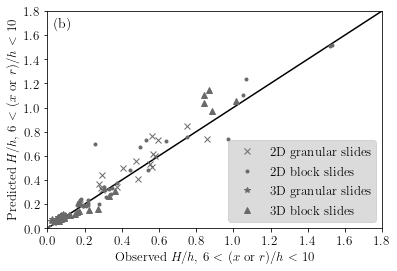

In [14]:
make_QQ_pred_FWU_3(X_test_combined_pro ,y_test_combined_B_Hm, predict_test)

In [15]:
def make_QQ_pred_FWU_5(X_test_combined,y_test_combined,predictions_combined_grid_search):

    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'DeJavu Serif'
    fig, ax = plt.subplots()

    #plt.rcParams['text.usetex'] = True # "font.family": "Helvetica"
    #rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    #rc('text', usetex=True)
    plt.xlabel(r'Observed $H / h$, 15 $<$ ($x$ or $r$)/$h$ $<$ 22', fontsize=13)
    plt.ylabel(r'Predicted $ H / h$, 15 $<$ ($x$ or $r$)/$h$ $<$ 22', fontsize=13)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)  
    max_val = float(np.amax(y_test_combined))
    O = np.linspace(0,2,1000)
    plt.plot(O,O, color = 'k')
    plt.xlim([0,1.8])
    plt.ylim([0,1.8])
    
    count_gran = 0
    count_3dgran = 0 
    count_2dsolid = 0
    count_3dsolid = 0
    
   
            
    for i in range(X_test_combined.shape[0]):    
        if X_test_combined[i,4] == 0 and X_test_combined[i,5] == 0: 
            count_gran += 1 
        elif X_test_combined[i,4] == 1 and X_test_combined[i,5] == 0:
            count_3dgran += 1             
        elif X_test_combined[i,4] == 0 and X_test_combined[i,5] == 1:
            count_2dsolid += 1 
        elif X_test_combined[i,4] == 1 and X_test_combined[i,5] == 1:
            count_3dsolid += 1 
          
            

        
    print("Count each type in results", count_gran, count_3dgran,count_2dsolid,count_3dsolid)
    
    ys_count_gran = np.zeros((count_gran,))
    ys_count_gran_preds = np.zeros((count_gran,))
    
    ys_count_3dgran = np.zeros((count_3dgran,))
    ys_count_3dgran_preds = np.zeros((count_3dgran,))
    
    ys_count_2dsolid = np.zeros((count_2dsolid,))
    ys_count_2dsolid_preds = np.zeros((count_2dsolid,))
    
    ys_count_3dsolid = np.zeros((count_3dsolid,))
    ys_count_3dsolid_preds = np.zeros((count_3dsolid,))
    


    count_gran_c = 0
    count_3dgran_c = 0
    count_2dsolid_c = 0
    count_3dsolid_c = 0
            
    use_X_test_combined = []
    use_y_test_combined = []
    use_predictions_combined_grid_search = []
    for i in range(X_test_combined.shape[0]):
        if X_test_combined[i,-2] > 14.99 and X_test_combined[i,-2] < 22.01:
            use_X_test_combined.append(X_test_combined[i]) 
            use_y_test_combined.append(y_test_combined[i])
            use_predictions_combined_grid_search.append(predictions_combined_grid_search[i])
    use_X_test_combined = np.array(use_X_test_combined)
    use_y_test_combined = np.array(use_y_test_combined)
    use_predictions_combined_grid_search = np.array(use_predictions_combined_grid_search)
    print(use_X_test_combined.shape)    
    print(use_y_test_combined)    
        
    for i in range(use_X_test_combined.shape[0]):    
        if use_X_test_combined[i,4] == 0 and use_X_test_combined[i,5] == 0: 
            ys_count_gran[count_gran_c] = use_y_test_combined[i][0]
            ys_count_gran_preds[count_gran_c] = use_predictions_combined_grid_search[i][0]
            count_gran_c += 1
        elif use_X_test_combined[i,4] == 1 and use_X_test_combined[i,5] == 0:
            ys_count_3dgran[count_3dgran_c] = use_y_test_combined[i][0]
            ys_count_3dgran_preds[count_3dgran_c] = use_predictions_combined_grid_search[i][0]
            count_3dgran_c += 1
        elif use_X_test_combined[i,4] == 0 and use_X_test_combined[i,5] == 1:
            ys_count_2dsolid[count_2dsolid_c] = use_y_test_combined[i][0]
            ys_count_2dsolid_preds[count_2dsolid_c] = use_predictions_combined_grid_search[i][0]
            count_2dsolid_c += 1 
        elif use_X_test_combined[i,4] == 1 and use_X_test_combined[i,5] == 1:
            ys_count_3dsolid[count_3dsolid_c] = use_y_test_combined[i][0]
            ys_count_3dsolid_preds[count_3dsolid_c] = use_predictions_combined_grid_search[i][0]
            count_3dsolid_c += 1  
    
    print(ys_count_gran.shape, ys_count_2dsolid.shape, ys_count_3dsolid.shape, ys_count_3dgran.shape)
    print(ys_count_gran_preds.shape, ys_count_3dgran_preds.shape, ys_count_2dsolid_preds.shape,ys_count_3dsolid_preds.shape)
    
    ax.plot(ys_count_gran , ys_count_gran_preds, "x", color = 'dimgray' , label = '2D granular slides')
    ax.plot(ys_count_2dsolid , ys_count_2dsolid_preds, ".", color = 'dimgray' , label = '2D block slides')
    ax.plot(ys_count_3dgran , ys_count_3dgran_preds, "*", color = 'dimgray' , label = '3D granular slides')
    ax.plot(ys_count_3dsolid ,ys_count_3dsolid_preds, "^", color = 'dimgray' , label = '3D block slides')
    
    matplotlib.pyplot.text(0.02,0.97,"(c)", horizontalalignment='left', verticalalignment='top', fontsize=14, transform = ax.transAxes)
    ax.legend(fontsize=13, loc="lower right",facecolor='lightgrey')
    #plt.savefig("hallpaper_newer_allfourjpgc", dpi=1200,bbox_inches="tight")
    plt.show()

Count each type in results 43 18 35 22
(93, 12)
[[0.17229167 0.08708333 0.05354167 0.040625   0.026875   0.01770833]
 [0.089375   0.048125   0.02854167 0.02020833 0.01229167 0.011875  ]
 [1.01416667 0.51583333 0.455      0.37583333 0.29333333 0.20791667]
 [0.11770833 0.0575     0.03395833 0.02375    0.01479167 0.00854167]
 [0.36541667 0.27875    0.17333333 0.11958333 0.07916667 0.05291667]
 [0.05479167 0.03       0.01895833 0.01375    0.00875    0.00916667]
 [0.06041667 0.036875   0.02541667 0.02       0.014375   0.01791667]
 [0.065      0.0925     0.065      0.05583333 0.04291667 0.03291667]
 [0.86791667 0.615      0.44791667 0.29125    0.19208333 0.12583333]
 [0.07104167 0.05145833 0.03833333 0.030625   0.02145833 0.01145833]
 [0.84208333 0.57541667 0.37458333 0.285      0.18458333 0.11875   ]
 [0.88708333 0.66541667 0.48791667 0.38625    0.27583333 0.18833333]
 [0.32875    0.23833333 0.15583333 0.11375    0.075      0.04958333]
 [0.84166667 0.66708333 0.45208333 0.34041667 0.2233333

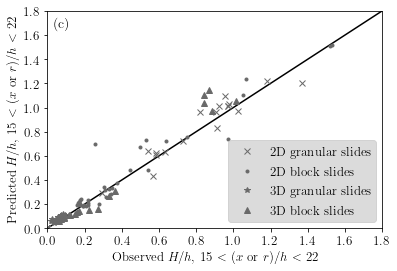

In [16]:
make_QQ_pred_FWU_5(X_test_combined_pro ,y_test_combined_B_Hm, predict_test)